#  【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。


・何を学習し、何を予測するのか

・どのようなファイルを作りKaggleに提出するか#

・提出されたものはどういった指標値で評価されるのか

In [137]:
# 各種インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [138]:
# ローカルからデータ読み込み
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")


In [242]:
print(df_test.shape)

(48744, 121)


### 何を学習し、何を予測するのか

顧客の返済能力を学習し、債務不履行リスクを予測する。

### どのようなファイルを作りKaggleに提出するか
### 提出されたものはどういった指標値で評価されるのか


提出物は 、予測された確率と観測されたターゲットの間の受信機動作特性　 ＲＯＣ曲線下面積で評価されます。

提出ファイル

SK_ID_CURR テストセットのそれぞれについて、TARGET変数の確率を予測する必要があります。ファイルにはヘッダーが含まれ、次の形式である必要があります。


```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。


精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。


# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。



In [139]:
# カテゴリ変数をラベルエンコーディング
# カテゴリ変数(dtype=objectの列)を抜き出す

def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']

    return feats

obj= _get_categorical_features(df_train)
print(obj)
print(len(obj))

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
16


In [140]:
# カテゴリ変数を数値化
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df

_factorize_categoricals(df_train, obj)
_factorize_categoricals(df_test, obj)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,0,0,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,0,0,0,1,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,0,0,1,0,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,0,1,0,1,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [141]:
# 欠損値を平均値で置換
df_train.fillna(df_test.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [142]:
X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

In [143]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [199]:
# データ分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( X, y, train_size=0.75, random_state=0)
print(x_train, x_test, y_train, y_test)

        SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
45598       152807                   1            0             1   
155019      279684                   0            1             1   
147473      270998                   0            1             0   
56665       165670                   0            1             0   
32334       137488                   0            0             0   
...            ...                 ...          ...           ...   
122579      242114                   0            1             0   
304137      452374                   0            1             0   
152315      276545                   1            0             0   
117952      236776                   0            0             1   
305711      454197                   0            1             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
45598                 1             1          157500.0    180000.0   
155019                0      

In [145]:
# ランダムフォレストで学習

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(x_train, y_train)

y_pred = clf_rf.predict(x_test)

In [146]:
y_pred = clf_rf.predict_proba(x_test)

In [147]:
y_pred[:,1]

array([0.17, 0.11, 0.11, ..., 0.1 , 0.21, 0.06])

In [148]:
out = {}
from sklearn.metrics import roc_auc_score

allin = roc_auc_score(y_test, y_pred[:,1])
out['基本の結果'] = allin

out

{'基本の結果': 0.7070547790566888}

# 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。


正しく提出が行えていれば、精度は低くても構いません。

In [149]:
XX = df_test

In [150]:
y_pred = clf_rf.predict_proba(XX)

In [151]:
y_pred

array([[0.84, 0.16],
       [0.88, 0.12],
       [0.94, 0.06],
       ...,
       [0.91, 0.09],
       [0.9 , 0.1 ],
       [0.77, 0.23]])

In [152]:
tmp = pd.DataFrame(y_pred[:,1], columns=["TARGET"])
tmp

,TARGET
0,0.16
1,0.12
2,0.06
3,0.07
4,0.15
...,...
48739,0.13
48740,0.14
48741,0.09
48742,0.10


In [153]:
submit = pd.concat([df_test['SK_ID_CURR'], tmp["TARGET"]], axis=1)
submit

,SK_ID_CURR,TARGET
0,100001,0.16
1,100005,0.12
2,100013,0.06
3,100028,0.07
4,100038,0.15
...,...,...
48739,456221,0.13
48740,456222,0.14
48741,456223,0.09
48742,456224,0.10


In [154]:
# kaggle用にCSV出力
submit.to_csv('kaggle_submit.csv', index=False)

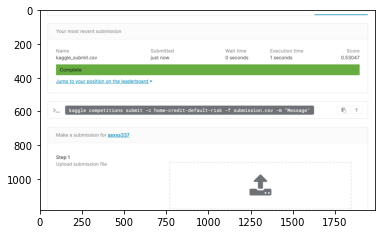

In [155]:
# 提出結果
%matplotlib inline
 
import matplotlib.image as mpimg
plt.imshow(mpimg.imread("submit.png"))

スコアは0.53。

# 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。


どの特徴量を使うか
どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。


精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

In [156]:
# 相関係数行列のヒートマップを作り、相関係数の高い関係を見つける。
corr_mat = df_train.corr(method='pearson')
print(corr_mat)

                            SK_ID_CURR    TARGET  NAME_CONTRACT_TYPE  \
SK_ID_CURR                    1.000000 -0.002108            0.001654   
TARGET                       -0.002108  1.000000           -0.030896   
NAME_CONTRACT_TYPE            0.001654 -0.030896            1.000000   
CODE_GENDER                   0.000707 -0.054718            0.008867   
FLAG_OWN_CAR                  0.001216 -0.021851            0.004022   
...                                ...       ...                 ...   
AMT_REQ_CREDIT_BUREAU_DAY    -0.002059  0.001898           -0.004914   
AMT_REQ_CREDIT_BUREAU_WEEK    0.001885 -0.001142           -0.014721   
AMT_REQ_CREDIT_BUREAU_MON     0.000333 -0.014678           -0.014307   
AMT_REQ_CREDIT_BUREAU_QRT     0.001092  0.002414           -0.018769   
AMT_REQ_CREDIT_BUREAU_YEAR    0.004353  0.018699           -0.048358   

                            CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                     0.000707      0.001216        

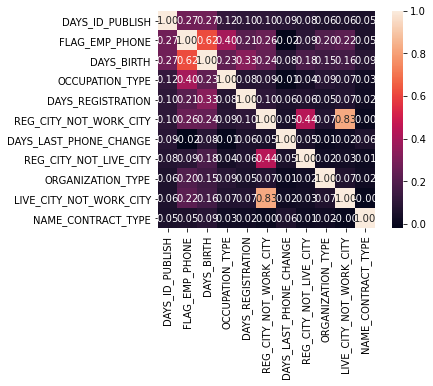

In [157]:
k = 11 #number of variables for heatmap
c = "DAYS_ID_PUBLISH"
cols = corr_mat.nlargest(k, c)[c].index
cm = np.corrcoef(df_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [158]:
df_train["FLAG_EMP_PHONE"]

0         1
1         1
2         1
3         1
4         1
         ..
307506    1
307507    0
307508    1
307509    1
307510    1
Name: FLAG_EMP_PHONE, Length: 307511, dtype: int64

In [159]:
df_train["REGION_RATING_CLIENT"]

0         2
1         1
2         2
3         2
4         2
         ..
307506    1
307507    2
307508    3
307509    2
307510    1
Name: REGION_RATING_CLIENT, Length: 307511, dtype: int64

In [160]:
# Feature Importance
fti = clf_rf.feature_importances_   

tmp = {}
imp_df = pd.DataFrame(columns=["feature", "importance"], index=range(len(X.columns)))

print('Feature Importances:')
for i, feat in enumerate(X.columns.values):
    tmp_se = pd.Series([feat, fti[i]], index=imp_df.columns)
    imp_df.iloc[i ,] = tmp_se
    
df_s = imp_df.sort_values('importance', ascending=False)
df_s.head(24)

Feature Importances:


,feature,importance
41,EXT_SOURCE_2,0.0553415
42,EXT_SOURCE_3,0.0507858
16,DAYS_BIRTH,0.0362996
18,DAYS_REGISTRATION,0.035357
19,DAYS_ID_PUBLISH,0.0352042
0,SK_ID_CURR,0.0338073
8,AMT_ANNUITY,0.0320104
17,DAYS_EMPLOYED,0.0318228
94,DAYS_LAST_PHONE_CHANGE,0.030705
7,AMT_CREDIT,0.0300146


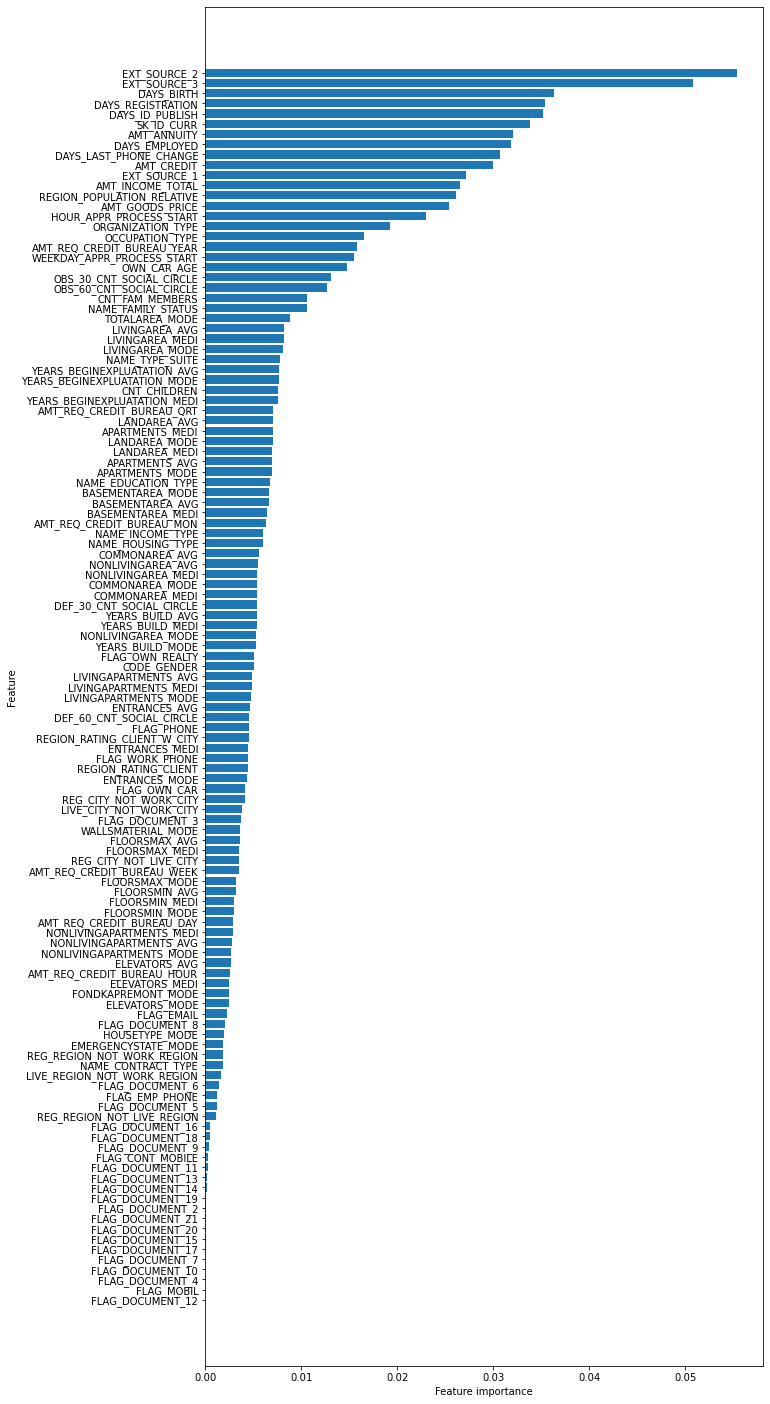

In [161]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df, x, y): 
    fig = plt.figure(figsize=(x, y))
    n_features = len(df) # 特徴量数(説明変数の個数)  
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
    plt.barh(range(n_features), f_imoprtance_plot, align='center') 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
    plt.xlabel('Feature importance') # x軸のタイトル
    plt.ylabel('Feature') # y軸のタイトル
    
    
plot_feature_importance(imp_df, 10, 25)

## どういう特徴量エンジニアリングを行うか？

案
    
①重要度上位勢だけでやってみる

②相関が高い説明変数同士で、よりTARGETと相関が高い方だけを残す

③説明変数を組み合わせて新しい変数にしてみる

④

In [244]:
# 重要度0.01〜の変数だけでやってみる

columns = df_s.head(24)["feature"].values
print(columns[5]) # SK_ID_CURRを一旦削除
columns = np.delete(columns, 5)

df_imp_001 = x_train[columns]
df_imp_001
df_imp_002 = x_test[columns]
df_imp_002
df_imp_003 = [columns]
df_imp_003

SK_ID_CURR


,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,EXT_SOURCE_1,...,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,OCCUPATION_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,NAME_FAMILY_STATUS
0,0.789654,0.159520,-19241,-5170.0,-812,20560.5,-2329,-1740.0,568800.0,0.752614,...,18,0,-1,0.000000,0,11.786027,0.0,0.0,2.0,0
1,0.291656,0.432962,-18064,-9118.0,-1623,17370.0,-4469,0.0,222768.0,0.564990,...,9,1,0,3.000000,1,11.786027,0.0,0.0,2.0,0
2,0.699787,0.610991,-20038,-2175.0,-3503,69777.0,-4458,-856.0,663264.0,0.501180,...,14,2,1,4.000000,2,5.000000,0.0,0.0,2.0,0
3,0.509677,0.612704,-13976,-2000.0,-4208,49018.5,-1866,-1805.0,1575000.0,0.525734,...,11,3,2,3.000000,3,11.786027,0.0,0.0,4.0,0
4,0.425687,0.500106,-13040,-4000.0,-4262,32067.0,-2191,-821.0,625500.0,0.202145,...,5,3,-1,1.983769,1,16.000000,0.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.648575,0.643026,-19970,-9094.0,-3399,17473.5,-5169,-684.0,412560.0,0.501180,...,16,12,-1,1.000000,3,11.786027,1.0,1.0,1.0,3
48740,0.684596,0.500106,-11186,-3015.0,-3003,31909.5,-1149,0.0,622413.0,0.501180,...,11,15,2,1.983769,2,11.786027,2.0,2.0,4.0,0
48741,0.632770,0.283712,-15922,-2681.0,-1504,33205.5,-3037,-838.0,315000.0,0.733503,...,12,3,-1,1.000000,3,4.000000,0.0,0.0,3.0,0
48742,0.445701,0.595456,-13968,-1461.0,-1364,25128.0,-2731,-2308.0,450000.0,0.373090,...,10,1,6,2.000000,2,11.786027,0.0,0.0,2.0,0


In [245]:
clf_rf.fit(df_imp_001, y_train)

y_pred_submit = clf_rf.predict_proba(df_imp_003)

In [249]:
y_pred_tmp = clf_rf.predict_proba(df_imp_002)

In [246]:
y_pred_submit[:,1]

array([0.08, 0.09, 0.01, ..., 0.08, 0.09, 0.17])

In [250]:
imp = roc_auc_score(y_test, y_pred_tmp[:,1])
out['重要度上位24'] = imp
out

{'基本の結果': 0.7070547790566888,
 '重要度上位24': 0.71784984237202,
 '重要度+標準化': 0.7151140908997431,
 '特徴量削除': 0.7107896768571732,
 '特徴量削除(TOP24)': 0.711937156562076}

### 重要度厳選の結果
auc_score : 0.71391

折角なので、厳選した変数を全部標準化してみる

In [230]:
# 標準化

sc = StandardScaler()
sc.fit(df_imp_001)
x_train_std = sc.transform(df_imp_001)
x_test_std = sc.transform(df_imp_002)
print(x_train_std)
print(x_test_std)

[[ 1.41231628e-03  6.45001303e-01  1.49592187e+00 ...  1.90844759e+00
   9.34915964e-01 -2.50013457e-01]
 [ 1.00893208e+00 -1.30515685e+00 -6.58277461e-01 ... -5.85177353e-01
  -1.65334245e-01 -2.50013457e-01]
 [-4.34900072e-01 -4.88266581e-02 -1.07551475e+00 ... -5.85177353e-01
  -1.26558445e+00 -1.26360778e+00]
 ...
 [-1.19826174e+00 -4.88266581e-02  2.86574931e-01 ...  6.61635116e-01
   9.34915964e-01  7.63580863e-01]
 [-6.52166320e-01  1.74881330e+00  3.72449785e-01 ... -5.85177353e-01
   3.13541638e+00 -2.50013457e-01]
 [ 8.66284176e-01 -4.88266581e-02  3.06726896e-01 ... -5.85177353e-01
   2.03516617e+00 -2.50013457e-01]]
[[-1.73932454 -2.07990448 -1.31207135 ... -0.1695732  -0.16533425
  -0.25001346]
 [ 0.81079079  0.98247561 -0.56209762 ... -0.58517735 -0.16533425
  -0.25001346]
 [-0.31536317 -1.91959738 -0.46706279 ...  0.01152153 -1.26558445
  -1.26360778]
 ...
 [ 0.97216108  0.769876   -1.05719478 ... -0.58517735 -0.16533425
  -0.25001346]
 [-2.46399998 -0.07425959  0.500231

In [231]:
clf_rf.fit(x_train_std, y_train)

y_pred_sub = clf_rf.predict_proba(x_test_std)


In [232]:
y_pred_sub[:,1]

array([0.29, 0.02, 0.08, ..., 0.01, 0.28, 0.03])

In [233]:
tmp = roc_auc_score(y_test, y_pred_sub[:,1])


out['重要度+標準化'] = tmp
out

{'基本の結果': 0.7070547790566888,
 '重要度上位24': 0.7147970731955335,
 '重要度+標準化': 0.7151140908997431,
 '特徴量削除': 0.7107896768571732,
 '特徴量削除(TOP24)': 0.711937156562076}

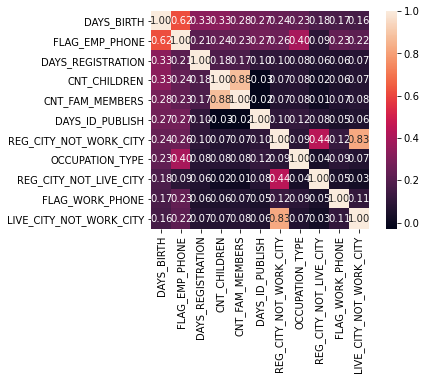

In [170]:
# TARGETとの相関係数の高い要素と相関の高い要素の削除
 #number of variables for heatmap

def _corr_ranking(c, k=11, df=df_train):
    cols = corr_mat.nlargest(k, c)[c].index
    cm = np.corrcoef(df[cols].values.T)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    
_corr_ranking("DAYS_BIRTH")

DAYS_BIRTHと相関のある要素
・FLAG_EMP_PHONE(職場の電話番号の登録有無)
→TARGETとの相関薄いし削除




In [171]:
del_list = []
del_list.append('FLAG_EMP_PHONE')

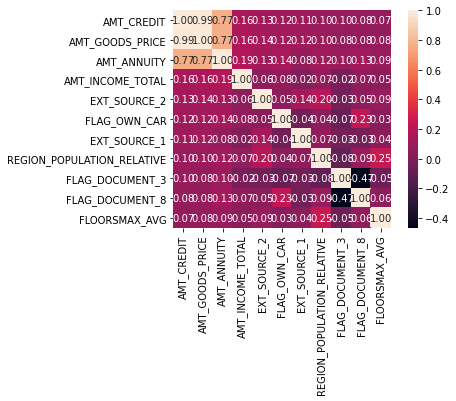

In [172]:
_corr_ranking("AMT_CREDIT")

AMT_CREDITと相関のある要素

・AMT_GOODS_PRICE →　ローンを組むための商品の価格

ほぼ与信額と同義なので削除。

・AMT_ANNUITY →　ローン支払額

こっちの方がTARGETとの相関が高いので、これを残す

In [173]:
del_list.append('AMT_CREDIT')
del_list.append('AMT_GOODS_PRICE')
del_list

['FLAG_EMP_PHONE', 'AMT_CREDIT', 'AMT_GOODS_PRICE']

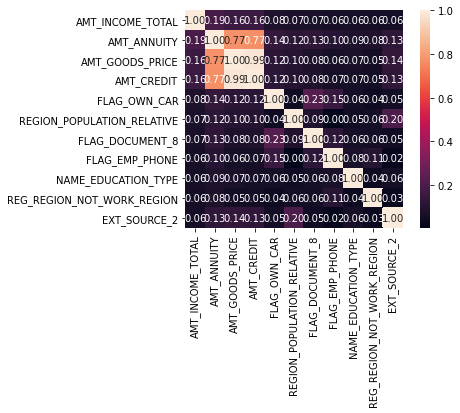

In [174]:
_corr_ranking("AMT_INCOME_TOTAL")

特に相関の高い特徴量はない？一旦保留

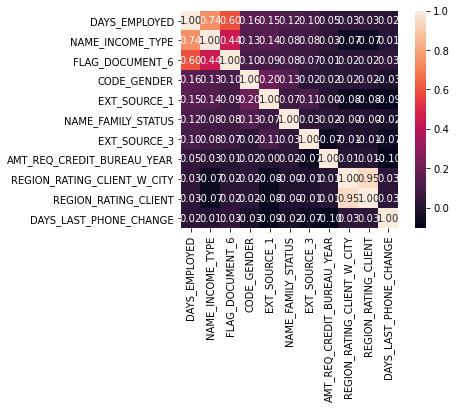

In [175]:
_corr_ranking("DAYS_EMPLOYED")

DAYS_EMPLOYED : 現在の職業に何日前に就業したか

NAME_INCOME_TYPE : 収入の種類、職業タイプ？国家公務員、実業家や産休など。

FLAG_DOCUMENT_6 : 提出書類6。上記と相関が高いことから職業や収入証明関係か？

DAYS_EMPLOYEDは日数、NAME_INCOME_TYPEはカテゴリ変数なので、残し
FLAG_DOCUMENT_6はTARGETとの相関も低いので、削除してみる

In [176]:
del_list.append('FLAG_DOCUMENT_6')

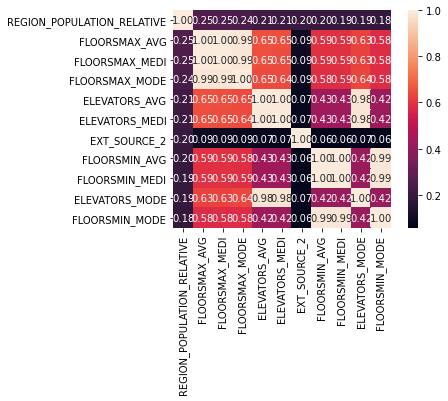

In [177]:
_corr_ranking("REGION_POPULATION_RELATIVE")

クライアントの住む地域の人口係数。大きい数字の方が人口が多い街に住んでいる。
全体的に相関も低め、住んでいる家とかとの相関の方が高い。一旦削除対象。

In [178]:
del_list.append('REGION_POPULATION_RELATIVE')

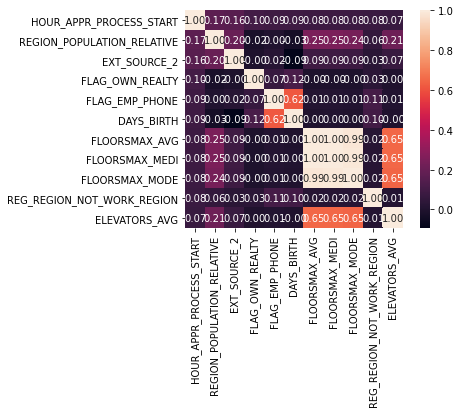

In [179]:
_corr_ranking("HOUR_APPR_PROCESS_START")

WEEKDAY_APPR_PROCESS_START　：　週のいつに融資の申請を行ったか
HOUR_APPR_PROCESS_START : 融資の申請を行った時間帯
    
相関も低いし削除。

In [180]:
del_list.append('WEEKDAY_APPR_PROCESS_START')
del_list.append('HOUR_APPR_PROCESS_START')

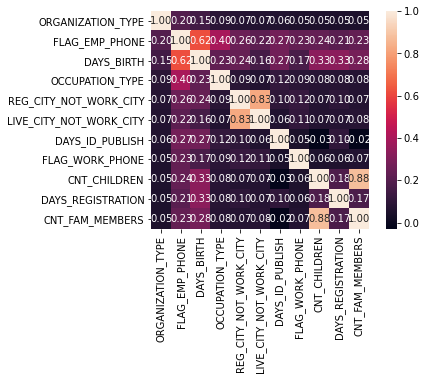

In [181]:
_corr_ranking("ORGANIZATION_TYPE")

OCCUPATION_TYPE : 職種
ORGANIZATION_TYPE : 会社種別

どちらもカテゴリ変数。一旦残す。

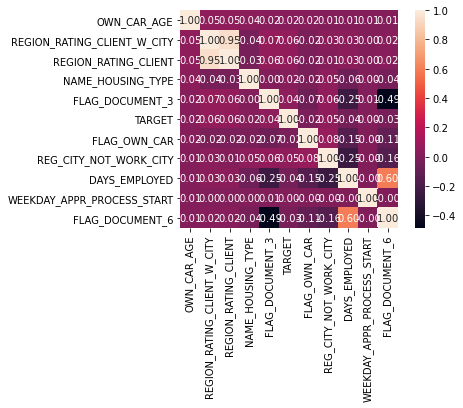

In [182]:
_corr_ranking("OWN_CAR_AGE")

車の年式？他と相関してないし一旦残す。

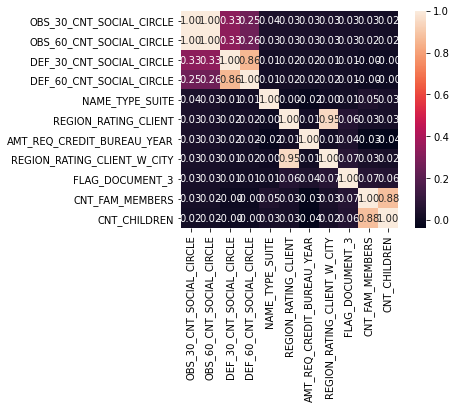

In [183]:
_corr_ranking("OBS_30_CNT_SOCIAL_CIRCLE")

OBS_30_CNT_SOCIAL_CIRCLE : 社会的サークルの中で30日延滞した割合？
    
正直よくわからない数字で、OBSは延滞した人がいる割合で、DEFは実際にdefaultが発生した割合？友達が延滞してたらリスクが上がる？

social circleの定義も不明。kaggleのディスカッションを見ても割とみんな困惑している。

一旦削除してみる。


In [184]:
tmp = ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]

del_list.extend(tmp)
del_list.append('SK_ID_CURR')
del_list

['FLAG_EMP_PHONE',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'FLAG_DOCUMENT_6',
 'REGION_POPULATION_RELATIVE',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'SK_ID_CURR']

キリがないので一旦ここまで。

In [213]:
df_del = x_train
df_del_test = x_test
for i in del_list:
    df_del = df_del.drop(i, axis=1)
    df_del_test = df_del_test.drop(i, axis=1)
    print(i)

FLAG_EMP_PHONE
AMT_CREDIT
AMT_GOODS_PRICE
FLAG_DOCUMENT_6
REGION_POPULATION_RELATIVE
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
OBS_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
SK_ID_CURR


In [214]:
df_del
df_del_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
42962,0,1,0,1,0,117000.0,20191.5,2,0,2,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
227307,0,0,0,0,0,450000.0,31261.5,0,2,1,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
290035,1,0,1,0,0,450000.0,45000.0,0,2,1,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
239833,0,0,1,1,1,360000.0,33025.5,0,0,0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
76427,0,0,1,0,0,675000.0,42840.0,0,0,2,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299074,0,1,0,0,0,99000.0,26640.0,3,0,0,...,0,0,0,0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
63712,0,0,0,1,1,450000.0,38362.5,0,1,0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
209943,0,1,0,1,0,112500.0,33642.0,0,3,0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,0,1,0,0,0,112500.0,24997.5,0,0,0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000


In [215]:
# 標準化
sc = StandardScaler()
sc.fit(df_del)
x_train_std = sc.transform(df_del)
x_test_std = sc.transform(df_del_test)
print(x_train_std)
print(x_test_std)

[[ 3.08671705 -1.38762939  1.39335828 ... -0.27206301 -0.52385992
   0.62565432]
 [-0.32396879  0.72057019  1.39335828 ... -0.27206301 -0.52385992
  -0.52478012]
 [-0.32396879  0.72057019 -0.7176905  ... -0.26117642  0.42542427
   0.04110052]
 ...
 [ 3.08671705 -1.38762939 -0.7176905  ... -0.26117642  0.42542427
   0.04110052]
 [-0.32396879 -1.38762939  1.39335828 ... -0.27206301 -0.52385992
  -1.09999734]
 [-0.32396879  0.72057019 -0.7176905  ... -0.27206301 -0.52385992
   1.77608877]]
[[-0.32396879  0.72057019 -0.7176905  ... -0.27206301 -0.52385992
   0.62565432]
 [-0.32396879 -1.38762939 -0.7176905  ... -0.27206301 -0.52385992
  -0.52478012]
 [ 3.08671705 -1.38762939  1.39335828 ... -0.27206301  2.94763375
  -1.09999734]
 ...
 [-0.32396879  0.72057019 -0.7176905  ... -0.27206301 -0.52385992
  -1.09999734]
 [-0.32396879  0.72057019 -0.7176905  ... -0.27206301  2.94763375
  -0.52478012]
 [-0.32396879  0.72057019  1.39335828 ...  0.89872496 -0.52385992
  -0.52478012]]


In [216]:
clf_rf.fit(x_train_std, y_train)

y_pred = clf_rf.predict_proba(x_test_std)

In [217]:
y_pred[:,1]

array([0.24, 0.03, 0.12, ..., 0.04, 0.33, 0.07])

In [218]:
tmp = roc_auc_score(y_test, y_pred[:,1])


out['特徴量削除'] = tmp
out

{'基本の結果': 0.7070547790566888,
 '重要度上位24': 0.7174352375840655,
 '重要度+標準化': 0.7141774035632511,
 '特徴量削除': 0.7107896768571732,
 '特徴量削除(TOP24)': 0.7070358568661363}

In [219]:
df_del_imp_001 = df_imp_001
df_del_imp_002 = df_imp_002

for i in del_list:
    if i in df_del_imp_001:
        df_del_imp_001 = df_del_imp_001.drop(i,axis=1)
    if i in df_del_imp_002:
        df_del_imp_002 = df_del_imp_002.drop(i,axis=1)

In [220]:
df_del_imp_002

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,OCCUPATION_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_FAMILY_STATUS
42962,0.182710,0.145543,-21774,-4611.0,-4653,20191.5,-2125,-2008.0,0.484936,117000.0,7,10,3.000000,11.786027,2.0,1
227307,0.669053,0.680139,-18499,-3052.0,-2028,31261.5,-2055,-728.0,0.624574,450000.0,0,0,1.000000,11.786027,2.0,1
290035,0.454279,0.173527,-18084,-8525.0,-1616,45000.0,-4159,-1273.0,0.501180,450000.0,11,3,0.000000,4.000000,1.0,0
239833,0.688145,0.440058,-12319,-12304.0,-4215,33025.5,-2532,-984.0,0.501180,360000.0,0,-1,1.000000,6.000000,3.0,1
76427,0.426409,0.081726,-10151,-2789.0,-2834,42840.0,-2516,0.0,0.501180,675000.0,19,4,2.000000,6.000000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299074,0.419168,0.500106,-9951,-2495.0,-872,26640.0,-828,-315.0,0.501180,99000.0,0,5,1.983769,11.786027,2.0,1
63712,0.713851,0.821443,-12569,-6506.0,-4506,38362.5,-4914,-529.0,0.534618,450000.0,10,0,1.000000,11.786027,3.0,1
209943,0.699828,0.643026,-20661,-4769.0,-2431,33642.0,365243,-329.0,0.501180,112500.0,5,-1,0.000000,11.786027,2.0,1
7914,0.044504,0.495666,-13860,-4720.0,-4718,24997.5,-812,-44.0,0.501180,112500.0,8,5,1.000000,11.786027,1.0,0


In [221]:
sc = StandardScaler()
sc.fit(df_del_imp_001)
x_train_std = sc.transform(df_del_imp_001)
x_test_std = sc.transform(df_del_imp_002)
print(x_train_std)
print(x_test_std)

[[ 1.41231628e-03  6.45001303e-01  1.49592187e+00 ... -4.14992361e-01
   9.34915964e-01 -2.50013457e-01]
 [ 1.00893208e+00 -1.30515685e+00 -6.58277461e-01 ... -1.57029474e+00
  -1.65334245e-01 -2.50013457e-01]
 [-4.34900072e-01 -4.88266581e-02 -1.07551475e+00 ... -1.26543691e-02
  -1.26558445e+00 -1.26360778e+00]
 ...
 [-1.19826174e+00 -4.88266581e-02  2.86574931e-01 ... -1.26543691e-02
   9.34915964e-01  7.63580863e-01]
 [-6.52166320e-01  1.74881330e+00  3.72449785e-01 ...  4.51484426e-01
   3.13541638e+00 -2.50013457e-01]
 [ 8.66284176e-01 -4.88266581e-02  3.06726896e-01 ... -1.26543691e-02
   2.03516617e+00 -2.50013457e-01]]
[[-1.73932454 -2.07990448 -1.31207135 ... -0.01265437 -0.16533425
  -0.25001346]
 [ 0.81079079  0.98247561 -0.56209762 ... -0.01265437 -0.16533425
  -0.25001346]
 [-0.31536317 -1.91959738 -0.46706279 ... -1.13705635 -1.26558445
  -1.26360778]
 ...
 [ 0.97216108  0.769876   -1.05719478 ... -0.01265437 -0.16533425
  -0.25001346]
 [-2.46399998 -0.07425959  0.500231

In [222]:
clf_rf.fit(x_train_std, y_train)

y_pred = clf_rf.predict_proba(x_test_std)

In [223]:
y_pred[:,1]

array([0.23, 0.01, 0.14, ..., 0.03, 0.24, 0.05])

In [224]:
tmp = roc_auc_score(y_test, y_pred[:,1])


out['特徴量削除(TOP24)'] = tmp
out

{'基本の結果': 0.7070547790566888,
 '重要度上位24': 0.7174352375840655,
 '重要度+標準化': 0.7141774035632511,
 '特徴量削除': 0.7107896768571732,
 '特徴量削除(TOP24)': 0.711937156562076}

取り敢えず5パターンやってみて最も良かったのはTOP24だけのモデル。

これをkaggleに提出してみる。



In [251]:
tmp2 = ()

In [252]:
tmp2 = pd.DataFrame(y_pred_submit[:,1], columns=["TARGET"])
tmp2

,TARGET
0,0.08
1,0.09
2,0.01
3,0.06
4,0.17
...,...
48739,0.01
48740,0.08
48741,0.08
48742,0.09


In [253]:
submit = pd.concat([df_test['SK_ID_CURR'], tmp2["TARGET"]], axis=1)
submit

,SK_ID_CURR,TARGET
0,100001,0.08
1,100005,0.09
2,100013,0.01
3,100028,0.06
4,100038,0.17
...,...,...
48739,456221,0.01
48740,456222,0.08
48741,456223,0.08
48742,456224,0.09


In [254]:
df_test['SK_ID_CURR']

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [255]:
# kaggle用にCSV出力
submit.to_csv('kaggle_submit_002.csv', index=False)

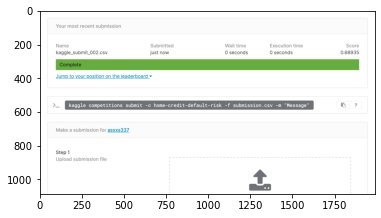

In [256]:
# 提出結果
%matplotlib inline
 
import matplotlib.image as mpimg
plt.imshow(mpimg.imread("submit002.png"))

0.68まで上昇。